# New Section

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
cd /gdrive/My\ Drive/

/gdrive/My Drive


In [ ]:
!git clone https://github.com/vivek081166/raw-audio-deep-learning.git

fatal: destination path 'raw-audio-deep-learning' already exists and is not an empty directory.


In [ ]:
cd raw-audio-deep-learning

/gdrive/My Drive/raw-audio-deep-learning


In [ ]:
# !pip3 install -r requirements.txt

In [ ]:
import os

DATA_AUDIO_DIR = './audio'
TARGET_SR = 8000
OUTPUT_DIR = './output'
OUTPUT_DIR_TRAIN = os.path.join(OUTPUT_DIR, 'train')
OUTPUT_DIR_TEST = os.path.join(OUTPUT_DIR, 'test')
AUDIO_LENGTH = 10000

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp37-none-any.whl size=5887 sha256=49ecf388231bd424ee21189d752cfbff61dda5294d8d2eb04790900f9916acc6
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:

from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import numpy as np
import pickle
from glob import glob
import librosa
import python_speech_features
from scipy.signal import butter , filtfilt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import matplotlib.pyplot as plt

# from constants import *

In [ ]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    # if not title:
    #     if mode == 'train':
    #         title = 'Normalized confusion matrix on train dataset'
    #     if mode == 'test':
    #         title = 'Normalized confusion matrix on test dataset'
    #     if mode == 'prob':
    #         title = 'Normalized confusion matrix on Non-Overlapping test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(7,7))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[0]),
           yticks=np.arange(cm.shape[1]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel= 'True label',
           xlabel='Predicted label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(12)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(10)

        
                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [ ]:
def get_data(file_list, progress_bar=False):
    def load_into(_filename, _x, _y):
        with open(_filename, 'rb') as f:
            audio_element = pickle.load(f)
            _x.append(audio_element['audio'])
            _y.append(int(audio_element['class_id']))

    x, y = [], []
    for filename in file_list:
        load_into(filename, x, y)
    return np.array(x), np.array(y)

In [ ]:
train_files = glob(os.path.join(OUTPUT_DIR_TRAIN, '**.pkl'))
x_tr, y_tr = get_data(train_files)
# y_tr = to_categorical(y_tr, num_classes=num_classes)

test_files = glob(os.path.join(OUTPUT_DIR_TEST, '**.pkl'))
x_te, y_te = get_data(test_files)
# y_te = to_categorical(y_te, num_classes=num_classes)

In [ ]:
x_tr.shape

(832, 10000, 1)

In [ ]:
y_tr.shape

(832,)

In [ ]:
ind4 = (y_tr==4).nonzero()[0]
y_tr = np.delete(y_tr, ind4)
print((y_tr==4).nonzero()[0])

x_tr = np.delete(x_tr, ind4 , axis=0)
x_tr.shape

[]


(539, 10000, 1)

In [ ]:
ind4 = (y_te==4).nonzero()[0]
y_te = np.delete(y_te, ind4)
print((y_te==4).nonzero()[0])

x_te = np.delete(x_te, ind4 , axis=0)
x_te.shape

[]


(25, 10000, 1)

In [ ]:
ind2 = (y_tr==2).nonzero()[0]
y_tr = np.delete(y_tr, ind2)
print((y_tr==2).nonzero()[0])

x_tr = np.delete(x_tr, ind2 , axis=0)
x_tr.shape

[]


(520, 10000, 1)

In [ ]:
ind2 = (y_te==2).nonzero()[0]
y_te = np.delete(y_te, ind2)
print((y_te==2).nonzero()[0])

x_te = np.delete(x_te, ind2 , axis=0)
x_te.shape

[]


(25, 10000, 1)

In [ ]:
# LPF compressed
def LPF(signal):    
    fc =300
    sr = 22050
    w = fc/(sr/2)
    b,a = butter(3,w , btype = "lowpass")

    x = filtfilt(b,a, signal)
    x = x/x.max()

    return x

# Normalize Data
def audio_norm(data):
    data = (data-min(data))/(max(data)-min(data)+0.0001)
    return data-0.5

In [ ]:
import python_speech_features

def get_features(data_file, duration = AUDIO_LENGTH, sr=TARGET_SR):

    # function to load files and extract feature

    data = []
    # data_file = np.load(data_file , allow_pickle=True)
    for i in range(len(data_file)):

        # try:
        # signal, sr = librosa.load( file_path, sr=sr, duration=duration,res_type='kaiser_fast') #duration=duration
        X = data_file[i,:,0]
        X = audio_norm(X)
        X = LPF(X)
        mfccs = np.mean(  librosa.feature.mfcc(y = X, sr=sr, n_mfcc=40).T  ,  axis=0)
        # print(mfccs.shape)
        fbank = np.mean(python_speech_features.logfbank(X , samplerate=sr , nfilt=40 , nfft=1024) , axis=0)
        ssc = np.mean(python_speech_features.base.ssc(X ,samplerate=sr) , axis=0)
        # powspec = python_speech_features.sigproc.powspec(X , NFFT=2)
        # print(powspec.shape)
                # print(fbank.shape)
        # except Exception as e:
        # print("Error encountered while parsing file: ", file_name)
        features = np.concatenate( (np.array(mfccs).reshape([-1,1]) , np.array(fbank).reshape([-1,1]) , np.array(ssc).reshape([-1,1])  ) , axis=0)
        data.append(features)
    return data

In [ ]:
tr_sounds = get_features(x_tr, duration = AUDIO_LENGTH) #Same duration for each file

ts_sounds = get_features(x_te, duration = AUDIO_LENGTH) #Same duration for each file

In [ ]:
tr_sounds = np.array(tr_sounds)
tr_sounds = tr_sounds[:,:,0]
tr_sounds.shape

(520, 106)

In [ ]:
ts_sounds = np.array(ts_sounds)
ts_sounds = ts_sounds[:,:,0]
ts_sounds.shape

(25, 106)

In [ ]:
y_tr.shape

(520,)

In [ ]:
y_te

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1])

In [ ]:
X = np.concat

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(tr_sounds, y_tr, train_size=0.8,random_state=1000, shuffle=True)

In [ ]:
lgb_params = {
    'boosting_type': 'gbdt',
    'objective': 'multi_class',
    'num_class': 4,    
    'metric' :'multi_logloss',
    # 'min_data_in_leaf':100 ,
    'is_unbalance' : True,
    'learning_rate': 0.08,
    'subsample': .9,
    'colsample_bytree': 0.5,
    'reg_alpha': .01,
    'reg_lambda': .01,
    'min_split_gain': 0.01,
    'min_child_weight': 2,
    'n_estimators': 100,
    'silent': -1,
    'verbose': -1,
    'max_depth':3,
}

In [ ]:
# params = {
# 'boosting_type': 'gbdt',
# 'objective': 'multiclass',
# 'metric': 'multi_logloss',
# 'num_class':4,
# 'min_data_in_leaf':150 ,
# 'feature_fraction':0.8,
# 'bagging_fraction':0.8,
# 'n_estimators': 100,
# 'bagging_freq':10,
# 'max_depth':2,
# 'num_leaves':10,
# 'learning_rate':0.04,
# 'subsample_for_bin' : 200
# }

In [ ]:
# gbm = lgb.train(
# params,
# lgb_train,
# num_boost_round=500,
# valid_sets=[lgb_train, lgb_val],
# early_stopping_rounds=10
# )

In [ ]:
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
clf = lgb.LGBMClassifier(**lgb_params)# , sample_weight=np.vectorize(w.get)(y_train) )

In [ ]:
clf.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
               importance_type='split', is_unbalance=True, learning_rate=0.08,
               max_depth=3, metric='multi_logloss', min_child_samples=20,
               min_child_weight=2, min_split_gain=0.01, n_estimators=100,
               n_jobs=-1, num_class=4, num_leaves=31, objective='multi_class',
               random_state=None, reg_alpha=0.01, reg_lambda=0.01, silent=-1,
               subsample=0.9, subsample_for_bin=200000, subsample_freq=0,
               verbose=-1)

In [ ]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(ts_sounds)
y_pred_val = clf.predict(X_val)

In [ ]:
accuracy_score(y_pred_train,y_train)

0.9698375870069605

In [ ]:
accuracy_score(y_pred_val,y_val)

0.6851851851851852

In [ ]:
accuracy_score(y_pred_test,y_te)

0.96

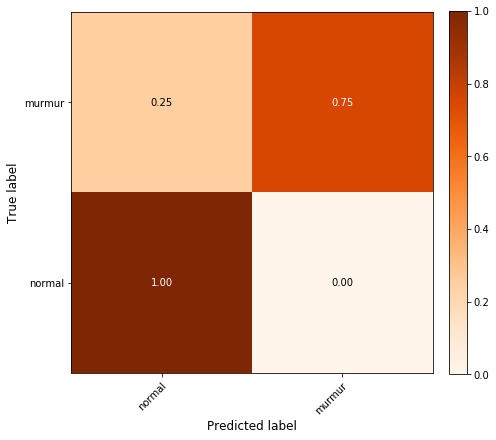

In [ ]:

# pred = clf.predict(ts_sounds)
pr = [y_pred_test[i] for i in range(len(y_te))]
Y = [y_te[i] for i in range(len(y_te))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , ['normal' , 'murmur' ] , normalize=1, cmap = plt.cm.Oranges ,mode='test', save=0 , name='RawData_Deep.png')

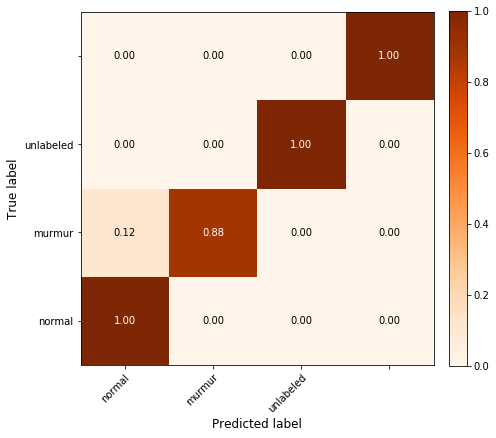

In [ ]:
# pred = clf.predict(ts_sounds)
pr = [y_pred_train[i] for i in range(len(y_train))]
Y = [y_train[i] for i in range(len(y_train))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , ['normal' , 'murmur' , 'unlabeled'] , normalize=1, cmap = plt.cm.Oranges ,mode='test', save=0 , name='RawData_Deep.png')

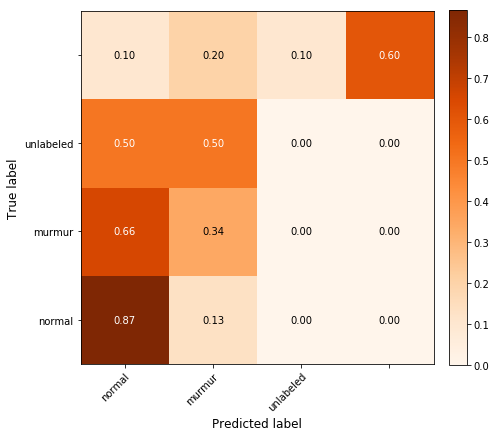

In [ ]:
# pred = clf.predict(ts_sounds)
pr = [y_pred_val[i] for i in range(len(y_val))]
Y = [y_val[i] for i in range(len(y_val))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , ['normal' , 'murmur' , 'unlabeled'] , normalize=1, cmap = plt.cm.Oranges ,mode='test', save=0 , name='RawData_Deep.png')

In [ ]:
unique, counts = np.unique(y_tr, return_counts=True)
dict(zip(unique, counts))

{0: 351, 1: 129, 2: 19, 3: 40}

In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import librosa
import tensorflow as tf
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.core import Activation, Dense
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
df = pd.read_pickle('pascal_pcg')

FileNotFoundError: ignored

In [ ]:
df[:5]

In [ ]:
df['labels'].unique()

In [ ]:
df.replace('artifact' , 0 , inplace=True)
df.replace('extrahls' , 1 , inplace=True)
df.replace('murmur' , 2 , inplace=True)
df.replace('normal' , 3 , inplace=True)
df.replace('extrastole' , 4 , inplace=True)
df

In [ ]:
df.reset_index(inplace=True)

In [ ]:
df.loc[124,'x']

array([-0.0062011 , -0.00689478, -0.00708609, ...,  0.00748599,
        0.00406206,  0.        ], dtype=float32)

In [ ]:
X = []

for i in range(len(df)):
    x = df.loc[i , 'x']
    x = (x- np.mean(x))/ np.std(x)
    x = librosa.util.fix_length(x , 10000)
    X.append(x)
df['x_new'] = X

In [ ]:
x = np.stack(df['x_new'].values, axis=0)
# y = np.stack(df['labels'].values, axis=0)
x.shape

(585, 10000)

In [ ]:
y = []

for i in range(len(df)):

    if df.loc[i,'labels']==3:
        y.append([1,0])
    else:
        y.append([0,1])
y = np.array(y)
y.shape

(585, 2)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y , test_size=0.15)
print("x_train: {0}, x_test: {1}".format(x_train.shape, x_test.shape))
print("y_train: {0}, y_test: {1}".format(y_train.shape, y_test.shape))

x_train: (497, 10000), x_test: (88, 10000)
y_train: (497, 2), y_test: (88, 2)


In [ ]:
x_train = np.expand_dims(x_train , axis=-1)
x_test = np.expand_dims(x_test , axis=-1)
x_train.shape

(497, 10000, 1)

In [ ]:
# y_train = to_categorical(y_train)
# y_test = to_categorical(y_test)
# print(y_train[0])

[0. 0. 1. 0. 0.]


In [ ]:
df.groupby(['labels']).count()

,index,File_name,x,x_new
labels,,,,
0,40,40,40,40
1,19,19,19,19
2,129,129,129,129
3,351,351,351,351
4,46,46,46,46


In [ ]:
num_classes = 2
AUDIO_LENGTH = df.loc[0,'x_new'].shape[0]
AUDIO_LENGTH

10000

In [ ]:
m = Sequential()
m.add(Conv1D(64,
                input_shape=[AUDIO_LENGTH, 1],
                kernel_size=80,
                strides=4,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))
m.add(Conv1D(64,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))
m.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))
m.add(Conv1D(128,
                kernel_size=3,
                strides=1,
                padding='same',
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(l=0.0001)))
m.add(BatchNormalization())
m.add(Activation('relu'))
m.add(MaxPooling1D(pool_size=4, strides=None))
m.add(Lambda(lambda x: K.mean(x, axis=1)))  # Same as GAP for 1D Conv Layer
m.add(Dense(num_classes, activation='sigmoid'))

In [ ]:
m.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_32 (Conv1D)           (None, 2500, 64)          5184      
_________________________________________________________________
batch_normalization_32 (Batc (None, 2500, 64)          256       
_________________________________________________________________
activation_32 (Activation)   (None, 2500, 64)          0         
_________________________________________________________________
max_pooling1d_32 (MaxPooling (None, 625, 64)           0         
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 625, 64)           12352     
_________________________________________________________________
batch_normalization_33 (Batc (None, 625, 64)           256       
_________________________________________________________________
activation_33 (Activation)   (None, 625, 64)          

In [ ]:
m.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])

In [ ]:
# reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_lr=0.0001, verbose=1)
batch_size = 228

m.fit(x=x_train,
            y=y_train,
            batch_size=batch_size,
            epochs=50,
            verbose=1,
            shuffle=True,
            validation_data=(x_test, y_test))
            # callbacks=[reduce_lr])

Epoch 1/50
3/3 [==============================] - 0s 60ms/step - loss: 0.2324 - accuracy: 0.9598 - val_loss: 0.7738 - val_accuracy: 0.6818
Epoch 2/50
3/3 [==============================] - 0s 39ms/step - loss: 0.2118 - accuracy: 0.9698 - val_loss: 0.7806 - val_accuracy: 0.6591
Epoch 3/50
3/3 [==============================] - 0s 38ms/step - loss: 0.2149 - accuracy: 0.9577 - val_loss: 0.6234 - val_accuracy: 0.6818
Epoch 4/50
3/3 [==============================] - 0s 38ms/step - loss: 0.2111 - accuracy: 0.9477 - val_loss: 0.9884 - val_accuracy: 0.6818
Epoch 5/50
3/3 [==============================] - 0s 38ms/step - loss: 0.2224 - accuracy: 0.9517 - val_loss: 0.6279 - val_accuracy: 0.6818
Epoch 6/50
3/3 [==============================] - 0s 38ms/step - loss: 0.1845 - accuracy: 0.9638 - val_loss: 1.0399 - val_accuracy: 0.6818
Epoch 7/50
3/3 [==============================] - 0s 38ms/step - loss: 0.1832 - accuracy: 0.9759 - val_loss: 0.6628 - val_accuracy: 0.6705
Epoch 8/50
3/3 [===========

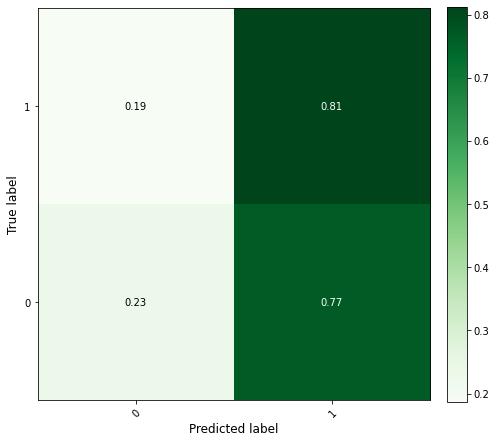

In [ ]:
pred = m.predict(x_test)
pr = [np.argmax(pred[i]) for i in range(len(y_test))]
Y = [np.argmax(y_test[i]) for i in range(len(y_test))]

# for i in range(len(y_test)):
#     pred.append(np.argmax(m.predict(x_test[i])))
#     Y.append(np.argmax(y_test[i]))

conf_plotter(Y , pr , [0,1] , normalize=1, cmap = plt.cm.Greens ,mode='test', save=0 , name='RawData_Deep.png')

In [ ]:
pred.shape

(486, 2)